## Classification fine-tuning

We will modify and fine-tune the GPT model we previously implemented and pretrained.

In [6]:
## Let's donwload the dataset
from IPython.display import Image
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path)/"SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    with urllib.request.urlopen(url) as response: # Download the file
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    
    with zipfile.ZipFile(zip_path, "r") as zip_ref:  # Unzips the file
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

In [7]:
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [8]:
import pandas as pd 
df = pd.read_csv(
    data_file_path, sep="\t", header=None, names =["Label", "Text"]
)
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


Let’s examine the class label distribution:

In [9]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


For simplicity, and because we prefer a small dataset, we choose to undersample the dataset to include 747 instances
from each class.

In [10]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0] # counts the number of spam

    # Randomly samples “ham” instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # Combines ham_subset with spam
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])
    return balanced_df

In [11]:
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


Next we convert the "string" class labels "ham" and "spam" integers class labels 0 and 1, respectively:

In [12]:
print(balanced_df["Label"].unique())
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
balanced_df

['ham' 'spam']


,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [13]:
from sklearn.model_selection import train_test_split

X = balanced_df["Text"]
y = balanced_df["Label"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.125, random_state=42)

Let’s save the dataset as CSV (comma-separated value) files so we can reuse it later:

In [14]:
train_df = pd.DataFrame({
    "Text": X_train,
    "Label": y_train
})


test_df = pd.DataFrame({
    "Text": X_test,
    "Label": y_test
})

validation_df = pd.DataFrame({
    "Text": X_val,
    "Label": y_val
})
train_df


,Text,Label
2405,Please give it 2 or i will pick it up on Tues...,0
1315,Got but got 2 colours lor. One colour is quite...,0
1167,I am not having her number sir,0
5536,Aiyah ok wat as long as got improve can alread...,0
3515,I always chat with you. In fact i need money c...,0
...,...,...
2808,December only! Had your mobile 11mths+? You ar...,1
4073,Loans for any purpose even if you have Bad Cre...,1
784,You have an important customer service announc...,1
5278,URGENT! Your Mobile number has been awarded wi...,1


In [15]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

Now we will set up the PyTorch data loaders that will be used to train the model.

## Creating data loaders

In order to batch the text messages fo varying lengths, we have two options: 

Truncate all messages to the length of the smallest message
Pad all messages to the length of the longest message.


The first option is computationally cheaper, but it may result in significant information loss if shorter messages are much smaller than the average or longest messages,  potentially reducing model performance. So, we opt for the second option.

To implement batching, where all messages are padded to the length of the longest message in the dataset, we add padding tokens to all shorter messages. For this purpose, we use "<|endoftext|>" as a padding token.

However, instead of appending the string "<|endoftext|>" to each of the text
messages directly, we can add the token ID corresponding to "<|endoftext|>" to the
encoded text messages,

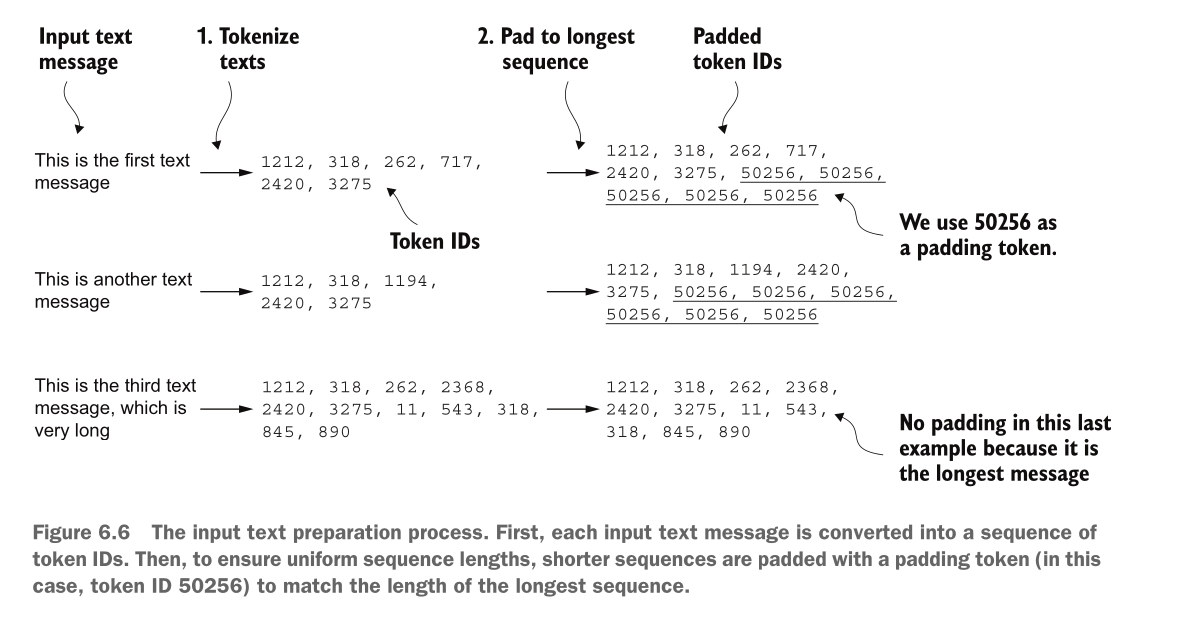

In [16]:
Image('./Screenshot from 2025-05-30 17-15-28.png')

We first need to implement a PyTorch dataset, which specifies how the data is loaded and processed before we can instantiate the data loaders.

In [17]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]
         
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            # truncates texts if they are longer than max_length
            self.max_length = max_length
            self.encoded_texts = [
                encoded_texts[:self.max_length]
                for encoded_texts in self.encoded_texts
            ]
       # Pads sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return(
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label,dtype=torch.long)
        )
    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

The SpamDataset class loads data from the CSV files we created earlier, tokenizes
the text using the GPT-2 tokenizer from tiktoken, and allows us to pad or truncate
the sequences to a uniform length determined by either the longest sequence or a
predefined maximum length. This ensures each input tensor is of the same size,
which is necessary to create the batches in the training data loader we implement
next:

In [18]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

train_dataset = SpamDataset(
    csv_file = "train.csv",
    max_length = None,
    tokenizer=tokenizer
)

val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

Using the datasets as inputs, we can instantiate the data loaders similarly to when we
were working with text data. However, in this case, the targets represent class labels
rather than the next tokens in the text. For instance, if we choose a batch size of 8,
each batch will consist of eight training examples of length max_length and the corresponding class label of each example.

In [19]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers= num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

Now that we’ve prepared the data, we need to prepare the model for fine-tuning.

Initializing a model with pretrained weights

In [20]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

In [21]:
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

In [22]:
model_configs ={
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

Next, we import the download_and_load_gpt2 function from the gpt_download.py
file and reuse the GPTModel class and load_weights_into_gpt function from pretrain-
ing (see chapter 5) to load the downloaded weights into the GPT model.

In [23]:

import sys
sys.path.append('../architecture/')  # or full path like '/home/user/project/my_module'
sys.path.append('../training/')  # or full path like '/home/user/project/my_module'


from gpt_download import download_and_load_gpt2
from gpt import GPTModel
from gpt_generate import load_weights_into_gpt

In [26]:
 model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
 settings, params = download_and_load_gpt2(
 model_size=model_size, models_dir="gpt2"
 )

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [27]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [30]:
from gpt_train import generate_text_simple
from gpt_train import text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

In [31]:
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


Before we start fine-tuning the model as a spam classifier, let’s see whether the model
already classifies spam messages by prompting it with instructions:

In [32]:
text_2 = (
"Is the following text 'spam'? Answer with 'yes' or 'no':"
" 'You are a winner you have been specially"
" selected to receive $1000 cash or a $2000 award.'"
)

In [35]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


Based on the output, it’s apparent that the model is struggling to follow instructions.
This result is expected, as it has only undergone pretraining and lacks instruction
fine-tuning. So, let’s prepare the model for classification fine-tuning.

Our goal is to modify the pretrained LLM to prepare it for classification fine-tuning. To do so, we replace the original output layer, with a smaller output layer that maps to two classes.

To get the model ready for classification fine-tuning, we first freeze the model, meaning
that we make all layers nontrainable:

In [36]:
for param in model.parameters():
    param.requires_grad = False

In [37]:
torch.manual_seed(123)
num_classes = 2 

model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

This new model.out_head output layer has its requires_grad attribute set to
True by default, which means that it’s the only layer in the model that will be
updated during training. Technically, training the output layer we just added is sufficient. However, fine-tuning additional layers can noticeably improve the predictive performance of the model. ) We also configure the last transformer block and the final LayerNorm
module, which connects this block to the output layer, to be trainable

In [38]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

Notice that if we pass the input 

inputs = tokenizer.encode("Do you have time")

to the model, we obtain:

Outputs:
tensor([[[-1.5854, 0.9904],
[-3.7235, 7.4548],
[-2.2661, 6.6049],
[-3.5983, 3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])

Now, Remember that we are interested in fine-tuning this model to return a class label
indicating whether a model input is “spam” or “not spam.” We don’t need to fine-tune all four output rows; instead, we can focus on a single output token. In particular, we will focus on the last row corresponding to the last output token.

Let’s understand why we are particularly interested in the last output token only.

We have already explored the attention mechanism, which establishes a relationship betweene each input token and every other input token, and the concept of a causal attention mask. This mask restricts a token’s focus to its current position and to those before it, ensuring that each token can only be influenced by itself and the preceding tokens.

the last token in a sequence accumulates the most information since it is the only token with access to data from all the
previous tokens. Therefore, in our spam classification task, we focus on this last token
during the fine-tuning process.

## Calculating the classification loss and accuracy

Only one small task remains before we fine-tune the model: we must implement the
model evaluation functions used during fine-tuning

In [40]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0,0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:,-1,:]
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )
        else:
            break
    return correct_predictions / num_examples

Let’s use the function to determine the classification accuracies across various datasets
estimated from 10 batches for efficiency:

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

In [45]:
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 48.75%
Validation accuracy: 49.12%
Test accuracy: 50.00%


However, before we begin fine-tuning the model, we must define the loss function
we will optimize during training. Our objective is to maximinze the spam classification accuracy of the model, which means that the preceeding code should output the correct class labels: 0 for non-spam and 1 for spam.

Because classification accuracy is not a differentiabke function, we use crossentropy loss as a proxy to maximize accuracy. Accordingly, the calc_loss_batch function remains the same, with one adjustment: we focus on optimizing only the last
token, model(input_batch)[:, -1, :], rather than all tokens, model(input_batch):

In [50]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:,-1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return lossNext, we will implement a training function to fine-tune the model,Next, we will implement a training function to fine-tune the model,

In [51]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss+=loss.item()
        else:
            break
    return total_loss/ num_batches

Similar to calculating the training accuracy, we now compute the initial loss for each
data set:

In [52]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model,device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")


Training loss: 2.581
Validation loss: 2.562
Test loss: 2.176


Next, we will implement a training function to fine-tune the model.

## Fine-tuning the model on supervised data

In [55]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs= [] ,[], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                    )
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader( val_loader, model, device, num_batches=eval_iter )

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

The evaluate_model function is identical to the one we used for pretraining:

In [56]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

Next, we initialize the optimizer, set the number of training epochs, and initiate the
training using the train_classifier_simple function.

In [59]:
import time 

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen =  \
    train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.363, Val loss 2.369
Ep 1 (Step 000050): Train loss 0.670, Val loss 0.635
Ep 1 (Step 000100): Train loss 0.560, Val loss 0.564
Training accuracy: 80.00% | Validation accuracy: 80.00%
Ep 2 (Step 000150): Train loss 0.454, Val loss 0.494
Ep 2 (Step 000200): Train loss 0.544, Val loss 0.435
Ep 2 (Step 000250): Train loss 0.332, Val loss 0.422
Training accuracy: 82.50% | Validation accuracy: 70.00%
Ep 3 (Step 000300): Train loss 0.570, Val loss 0.436
Ep 3 (Step 000350): Train loss 0.349, Val loss 0.438
Training accuracy: 95.00% | Validation accuracy: 87.50%
Ep 4 (Step 000400): Train loss 0.115, Val loss 0.267
Ep 4 (Step 000450): Train loss 0.267, Val loss 0.229
Ep 4 (Step 000500): Train loss 0.183, Val loss 0.180
Training accuracy: 95.00% | Validation accuracy: 87.50%
Ep 5 (Step 000550): Train loss 0.104, Val loss 0.195
Ep 5 (Step 000600): Train loss 0.076, Val loss 0.173
Training accuracy: 97.50% | Validation accuracy: 95.00%
Training completed in 0.96 minu

Now we must calculate the performance metrics for the training, validation, and
test sets across the entire dataset by running the following code, this time without
defining the eval_iter value:

In [60]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 95.87%
Validation accuracy: 96.49%
Test accuracy: 97.70%


## Using the LLM as a spam classifier

The following classify_review function follows data preprocessing steps similar
to those we used in the SpamDataset implemented earlier. Then, after processing
text into token IDs, the function uses the model to predict an integer class label,
similar to what we implemented in section 6.6, and then returns the corresponding
class name.

In [61]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pads sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
        predicted_label = torch.argmax(logits, dim=-1).item()
        
    return "spam" if predicted_label == 1 else "not spam"

Let’s try this classify_review function on an example text:

In [64]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

In [65]:
print(classify_review(
text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


Finally, let’s save the model in case we want to reuse the model later without having
to train it again. We can use the torch.save method:

In [70]:
torch.save(model.state_dict(), "review_classifier.pth")

Once saved, the model can be loaded:

In [72]:
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>